<a href="https://colab.research.google.com/github/coolkite/machine_translation/blob/main/English_to_French_translation_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.preprocessing import *
from keras.models import Model, load_model
from keras.layers import *
from keras.utils import *
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
with open('/content/small_vocab_en', 'r') as f:
    encoder_train = f.read().split('\n')
    
with open('/content/small_vocab_fr', 'r') as f:
    decoder_train = f.read().split('\n')

In [3]:
def tokenize(dataset):
  dataset = ["<BOS> " + train + " <EOS>" for train in dataset]
  token = text.Tokenizer(num_words = None)
  token.fit_on_texts(dataset)
  dataset = token.texts_to_sequences(dataset)
  return dataset, token.word_index

def padding(dataset):
  max_length = max([len(text) for text in dataset])
  dataset = pad_sequences(dataset, maxlen=max_length, padding = 'post', truncating = 'post')
  return max_length, dataset

In [4]:
model = load_model("/content/engToFrenchSmallDataset.h5")

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 17)]         0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 23)]         0           []                               
                                                                                                  
 embedding_34 (Embedding)       (None, 17, 300)      60600       ['input_35[0][0]']               
                                                                                                  
 embedding_35 (Embedding)       (None, 23, 300)      104100      ['input_36[0][0]']               
                                                                                           

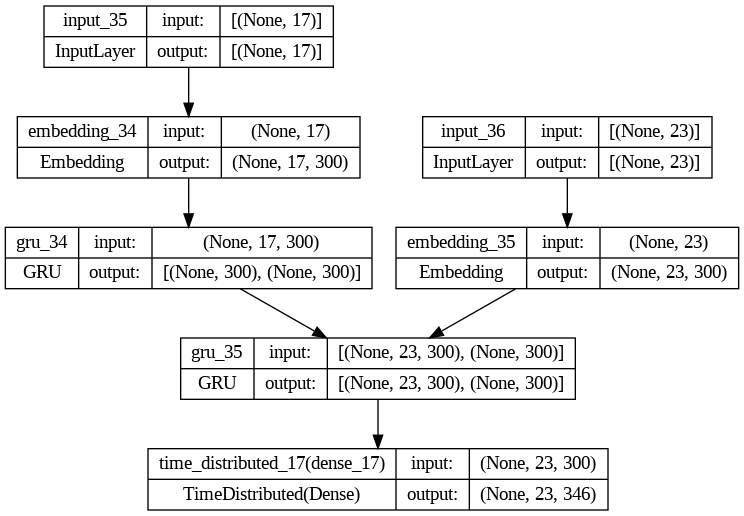

In [5]:
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 17)]              0         
                                                                 
 embedding_34 (Embedding)    (None, 17, 300)           60600     
                                                                 
 gru_34 (GRU)                [(None, 300),             541800    
                              (None, 300)]                       
                                                                 
Total params: 602,400
Trainable params: 541,800
Non-trainable params: 60,600
_________________________________________________________________


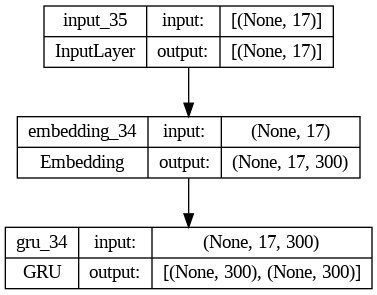

In [6]:
encoder_input = model.input[0]
encoder_embedding = model.layers[2](encoder_input)
encoder_output, encoder_hidden = model.layers[4](encoder_embedding)
encoder_model = Model(encoder_input, encoder_hidden)
encoder_model.summary()
plot_model(encoder_model, to_file='enc_model.png', show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 23)]         0           []                               
                                                                                                  
 embedding_35 (Embedding)       (None, 23, 300)      104100      ['input_36[0][0]']               
                                                                                                  
 input_3 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 gru_35 (GRU)                   [(None, 23, 300),    541800      ['embedding_35[1][0]',           
                                 (None, 300)]                     'input_3[0][0]']          

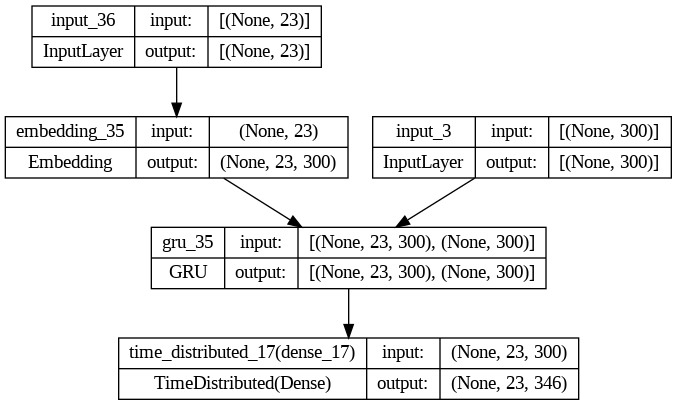

In [7]:
decoder_input = model.input[1]
initial_decoder_state = Input(shape=(300,), name='input_3')
decoder_embedding = model.layers[3](decoder_input)
decoder_output, dec_hid_state = model.layers[5](decoder_embedding, initial_state = initial_decoder_state)
decoder_dense = model.layers[6](decoder_output)

decoder_model = Model([decoder_input] + [initial_decoder_state], [decoder_dense] + [dec_hid_state])
decoder_model.summary()
plot_model(decoder_model, to_file='dec_model.png', show_shapes=True)

In [12]:
import pickle
with open('/content/engTokenizer.pickle', 'rb') as handle:
    eng_dict = pickle.load(handle)
with open('/content/freTokenizer.pickle', 'rb') as handle:
    fre_dict = pickle.load(handle)
reverse_fre_dict = {value:key for key, value in fre_dict.items()}

In [108]:
def tokenize(sentence, word_index):
  import re
  sentence = "<BOS> " + sentence + " <EOS>"
  sentence = sentence.lower()
  sentence = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", sentence)
  sentence = sentence.split(sep=" ")
  temp = sentence
  sentence = [word for word in temp if word != '']
  sentence = list(map(lambda key: word_index[key], sentence))
  return sentence, word_index

def padding(sentence, max_length):
  sentence = np.array(sentence)
  sentence = sentence.reshape(1,sentence.shape[0])
  sentence = pad_sequences(sentence, maxlen=max_length, padding = 'post', truncating = 'post')
  return sentence

In [118]:
eng_max_length = 17
fre_max_length = 23

def translate(orig_sentence):
  sentence, dic = tokenize(orig_sentence, eng_dict)
  sentence = padding(sentence, eng_max_length)

  enc_vector = encoder_model.predict(sentence, verbose=0)

  prev_word = np.zeros((1,1))
  prev_word[0,0] = fre_dict["bos"]
  trans_seq = []

  while True:
    output_token, last_hidden = decoder_model.predict([prev_word]+[enc_vector], verbose=0)
    pred_token = np.argmax(output_token[0,:])
    word = reverse_fre_dict[pred_token]

    enc_vector = last_hidden
    prev_word[0,0] = pred_token

    if word == "eos":
      break

    trans_seq.append(word)

  translation = " ".join(trans_seq)
  return translation

In [120]:
orig_sentence = "new jersey is warm"
translation = translate(orig_sentence)
print("Original english sentence: " + orig_sentence)
print("Translated french sentence: " + translation)

Original english sentence: new jersey is warm
Translated french sentence: new jersey est chaud au printemps
